# THE CONSUMPTION - SAVING MODEL 

Import sets and magics : 

In [167]:
import numpy as np
import pandas as pd
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from time import process_time
plt.style.use('seaborn-whitegrid')

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/j1/61s9lcn92sbd481n1w68fzr00000gn/T/ipykernel_81893/2722841480.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Model description

This model tries to replicate the intertemporal decision that is to whether consume now or save for later. 


So, the framework is as follows : 
- $W$ : the initial wealth. 
- $\beta$ : the time discount factor.
- $c_t$ : the amount of wealth consumed at t. 
- time is discrete and can be finite or infinite. 

Therefore, here is the model when time is finite : 

$$\begin{align*}
    V_t^*(W_t) &= \max_{0\leq c_t \leq W_t} \{ \sqrt{c_t} +\beta V_{t+1}(W_{t+1}) \} \\
    & \text{s.t.} \\
    W_{t+1} &= W_t -c_t\\
    c_t &\in \mathbb{N}_0, \, \forall t
\end{align*}$$



From these equations we can see that the aim is to maximize the discounted utility. We are looking for the level of consumption ($c^*_t$) at each period that maximizes the utility ($V^*_t$) at each period too.

The utility depends on the amount consumed at t but also on the amount consumed at t+1 which is discounted by $\beta$.

In the last period $V_T(W_T) = \max_{0\leq c_T \leq W_T}\{ \sqrt{c_T} \}$ because there is no tomorrow, and it is therefore optimal to consume everything, $c_T = W_T$.

## Analytical Solution : Backward Induction

### Let's try to solve analytically the simplest version of this model : 

In [168]:
# 1. Setup 
beta = 0.5
W = 5
T = 3 
V_opt = np.nan+np.zeros([W+1,T]) 
C_opt = np.nan + np.zeros([W+1,T]) # two empty matrices to fill during the loop (V_opt = optimal utility, C_opt = optimal consumption)
C_opt[:,T-1] = np.arange(W+1) 
V_opt[:,T-1] = np.sqrt(C_opt[:,T-1]) # fill last column with solutions (we already know what is consumed at last period)


# 2. Some visuals to understand the set up 
columns = ['t = 1', 't = 2', 't = 3']
index = [f'W = {w}' for w in range(W+1)]
df = pd.DataFrame(C_opt, index=index, columns=columns)
print("Optimal consumption matrix : Set up ")
print(df) 

columns = ['t = 1', 't = 2', 't = 3']
index = [f'C = {w}' for w in range(W+1)]
df = pd.DataFrame(V_opt, index=index, columns=columns)
print("Optimal utilities matrix : Set up")
print(df)

Optimal consumption matrix : Set up 
       t = 1  t = 2  t = 3
W = 0    NaN    NaN    0.0
W = 1    NaN    NaN    1.0
W = 2    NaN    NaN    2.0
W = 3    NaN    NaN    3.0
W = 4    NaN    NaN    4.0
W = 5    NaN    NaN    5.0
Optimal utilities matrix : Set up
       t = 1  t = 2     t = 3
C = 0    NaN    NaN  0.000000
C = 1    NaN    NaN  1.000000
C = 2    NaN    NaN  1.414214
C = 3    NaN    NaN  1.732051
C = 4    NaN    NaN  2.000000
C = 5    NaN    NaN  2.236068


In [169]:
# 3. Solve
# loop over periods
for t in range(T-2, -1, -1):  # from period T-2 until period 0, (from T-2 because T-1 is already filled)
    for w_now in range(W+1): 
        c_now = np.arange(w_now+1) 
        w_next = w_now - c_now 
        V_next = V_opt[w_next,t+1]
        V_guess = np.sqrt(c_now)+beta*V_next 
        V_opt[w_now,t] = np.amax(V_guess)
        C_opt[w_now,t] = np.argmax(V_guess)

# 4. Print solutions 
columns = ['t = 1', 't = 2', 't = 3']
index = [f'W = {w}' for w in range(W+1)]
df = pd.DataFrame(C_opt, index=index, columns=columns)
print("Optimal consumption matrix : Solution")
print(df) 

columns = ['t = 1', 't = 2', 't = 3']
index = [f'C = {w}' for w in range(W+1)]
df = pd.DataFrame(V_opt, index=index, columns=columns)
print("Optimal utilities matrix : Solution")
print(df)

Optimal consumption matrix : Solution
       t = 1  t = 2  t = 3
W = 0    0.0    0.0    0.0
W = 1    1.0    1.0    1.0
W = 2    1.0    1.0    2.0
W = 3    2.0    2.0    3.0
W = 4    3.0    3.0    4.0
W = 5    4.0    4.0    5.0
Optimal utilities matrix : Solution
          t = 1     t = 2     t = 3
C = 0  0.000000  0.000000  0.000000
C = 1  1.000000  1.000000  1.000000
C = 2  1.500000  1.500000  1.414214
C = 3  1.914214  1.914214  1.732051
C = 4  2.232051  2.232051  2.000000
C = 5  2.500000  2.500000  2.236068


Note here that we assume the level of wealth doesn't change across periods.

In [170]:
# 5. Simulate
C_backwards = np.empty(T) # create an empty vector of size 3 (number of periods)
W_now = 5 

for t in range(T):
    W_now = int(W_now)   # change the type to integer
    C_backwards[t] = C_opt[W_now,t]  # use the solution found in 3. 
    W_now = W_now-C_backwards[t] # consider the previous consumption now ! 

print(f'At t = 1, the agent consumes {C_backwards[0]} of his wealth. \nAt t = 2, he consumes {C_backwards[1]} of his wealth. \nAt t = 3, he consumes {C_backwards[2]} because he already consumed everything.')

At t = 1, the agent consumes 4.0 of his wealth. 
At t = 2, he consumes 1.0 of his wealth. 
At t = 3, he consumes 0.0 because he already consumed everything.


To understand those decisions, we can look at the optimal consumption matrix :
-  We see that **at t = 1 and W = 5** the agent consumes 4 if he behaves optimally
- Since 5 - 4 = 1, he has a level of wealth of 1. 
- Then, looking back at the optimal consumption matrix, **at t = 2 and W = 1**, the agent consumes 1 if he behaves optimally.
-  Lastly at t = 3, he has no more wealth left so he consumes 0.

### Let's play with the parameters and look at what happens

In [171]:
from modelproject import solve_backwards

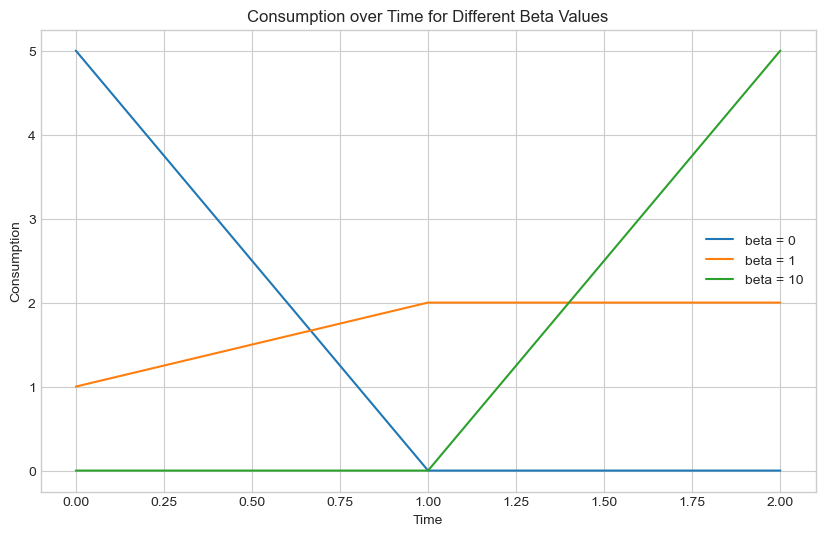

In [172]:
# parameters
W = 5  
T = 3  
W_now = 5
beta_values = [0, 1, 10 ]

# Plotting
plt.figure(figsize=(10, 6))
for beta in beta_values:
    C_backwards = solve_backwards(beta, W, T, W_now)
    plt.plot(np.arange(T), C_backwards, label=f'beta = {beta}')

plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Consumption over Time for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()

Here we can see how the behavior changes as the time discount factor varies. 

The main conclusions that we can draw from this graph is the fact that when there isn't a discount time factor the agent has a preference for the present. This means that he would rather spend everything than save for later. This trend is completely reversed when the time discount factor is very high ($\beta=10$). The agent prefers to spend everything at the last period. 

We can say that the discount factor is a parameter that allows us to tell whether or not someone has a preference for the future.

## Numerical Solution : Value Function Iteration

In [173]:
class wealth_ongrid():
    '''Simple class to implement consumption - saving problem on the grid'''

    def __init__(self,beta=.9, Wbar=10, ngrid=50):
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on wealth size
        self.ngrid = ngrid  # Number of grid points
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid = np.linspace(self.epsilon,Wbar,ngrid) # grid for both state and decision space
        
    def bellman(self,V0):
        '''Bellman operator, V0 is one-dim vector of values on grid'''
        c = self.grid  - self.grid[:,np.newaxis] # c = W - Wnext: current state in columns and choices in rows
        c[c==0] = self.epsilon # add small quantity to avoid log(0)
        mask = c>0 # mask (dummy variable for c==0?)for feasible choices 
        matV1 = np.full((self.ngrid,self.ngrid),-np.inf) # init V with -inf
        matV0 = np.repeat(V0.reshape(self.ngrid,1),self.ngrid,1) #current value function repeated in columns
        matV1[mask] = np.log(c[mask])+self.beta*matV0[mask] # maximand of the Bellman equation
        V1 = np.amax(matV1,axis=0,keepdims=False) # maximum in every column
        c1 = self.grid - self.grid[np.argmax(matV1,axis=0)] # consumption (index of maximum in every column)
        return V1, c1

In [174]:
from time import process_time
def vfi_solve(self, maxiter=1000, tol=1e-4, callback=None):
    '''Solves the model using VFI (successive approximations)'''
    tic = process_time() # Start the stopwatch / counter

    V0=np.log(self.grid) # on first iteration assume consuming everything
    for iter in range(maxiter):
        V1,c1=self.bellman(V0)
        if callback: callback(iter,self.grid,V1,c1) # callback for making plots
        if np.all(abs(V1-V0) < tol):
            toc = process_time() # Stop the stopwatch / counter
            print('vfi converged in ', iter, 'iterations, using',round(toc-tic, 5), 'seconds')
            break
        V0=V1
    else:  # when i went up to maxiter
        print('No convergence: maximum number of iterations achieved!')
    return V1,c1

# Add the solve method to the class
wealth_ongrid.solve = vfi_solve

In [180]:
model = wealth_ongrid(beta=0.95,Wbar=10,ngrid=10)
W=model.grid
V0=np.log(W) # on first iteration assume consuming everything
V1,c1 = model.bellman(V0)
V2,c2 = model.bellman(V1)
V,c = model.solve()
np.set_printoptions(precision=2, suppress=True)
print('W ', W)
print('Wnext\n', W[:,np.newaxis])
print('c=W-Wnext\n', W-W[:,np.newaxis])
print('V0', V0)
print('V1', V1)
print('V ', V)
print('c1', c1)
print('c2', c2)
print('c ', c)


vfi converged in  249 iterations, using 0.02264 seconds
W  [ 0.    1.11  2.22  3.33  4.44  5.56  6.67  7.78  8.89 10.  ]
Wnext
 [[ 0.  ]
 [ 1.11]
 [ 2.22]
 [ 3.33]
 [ 4.44]
 [ 5.56]
 [ 6.67]
 [ 7.78]
 [ 8.89]
 [10.  ]]
c=W-Wnext
 [[  0.     1.11   2.22   3.33   4.44   5.56   6.67   7.78   8.89  10.  ]
 [ -1.11   0.     1.11   2.22   3.33   4.44   5.56   6.67   7.78   8.89]
 [ -2.22  -1.11   0.     1.11   2.22   3.33   4.44   5.56   6.67   7.78]
 [ -3.33  -2.22  -1.11   0.     1.11   2.22   3.33   4.44   5.56   6.67]
 [ -4.44  -3.33  -2.22  -1.11   0.     1.11   2.22   3.33   4.44   5.56]
 [ -5.56  -4.44  -3.33  -2.22  -1.11   0.     1.11   2.22   3.33   4.44]
 [ -6.67  -5.56  -4.44  -3.33  -2.22  -1.11   0.     1.11   2.22   3.33]
 [ -7.78  -6.67  -5.56  -4.44  -3.33  -2.22  -1.11   0.     1.11   2.22]
 [ -8.89  -7.78  -6.67  -5.56  -4.44  -3.33  -2.22  -1.11   0.     1.11]
 [-10.    -8.89  -7.78  -6.67  -5.56  -4.44  -3.33  -2.22  -1.11   0.  ]]
V0 [-36.04   0.11   0.8    1.2    1.49 

### Let's play with some parameters : 

vfi converged in  0 iterations, using 0.01066 seconds


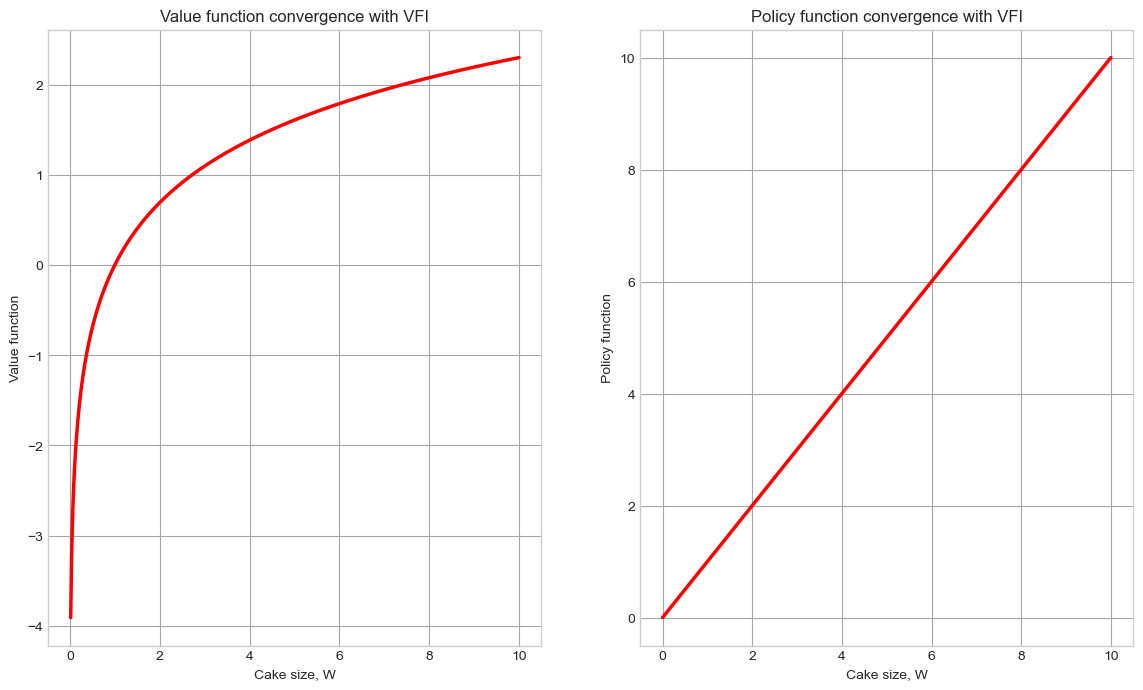

vfi converged in  18 iterations, using 0.17986 seconds


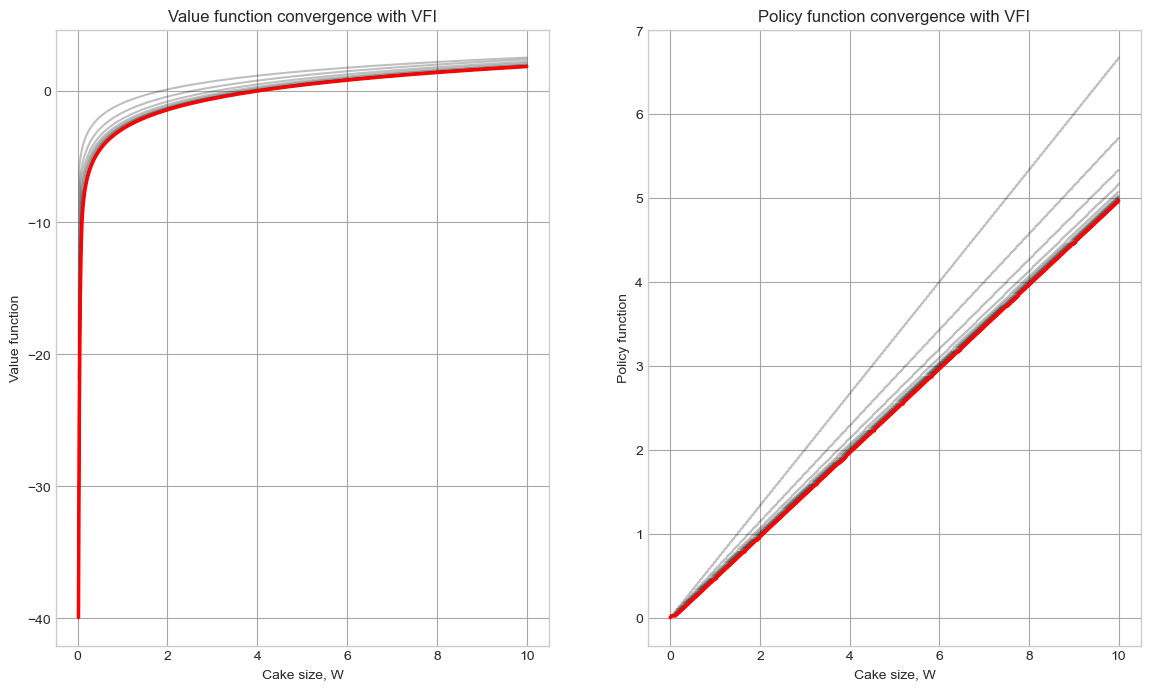

vfi converged in  121 iterations, using 0.90456 seconds


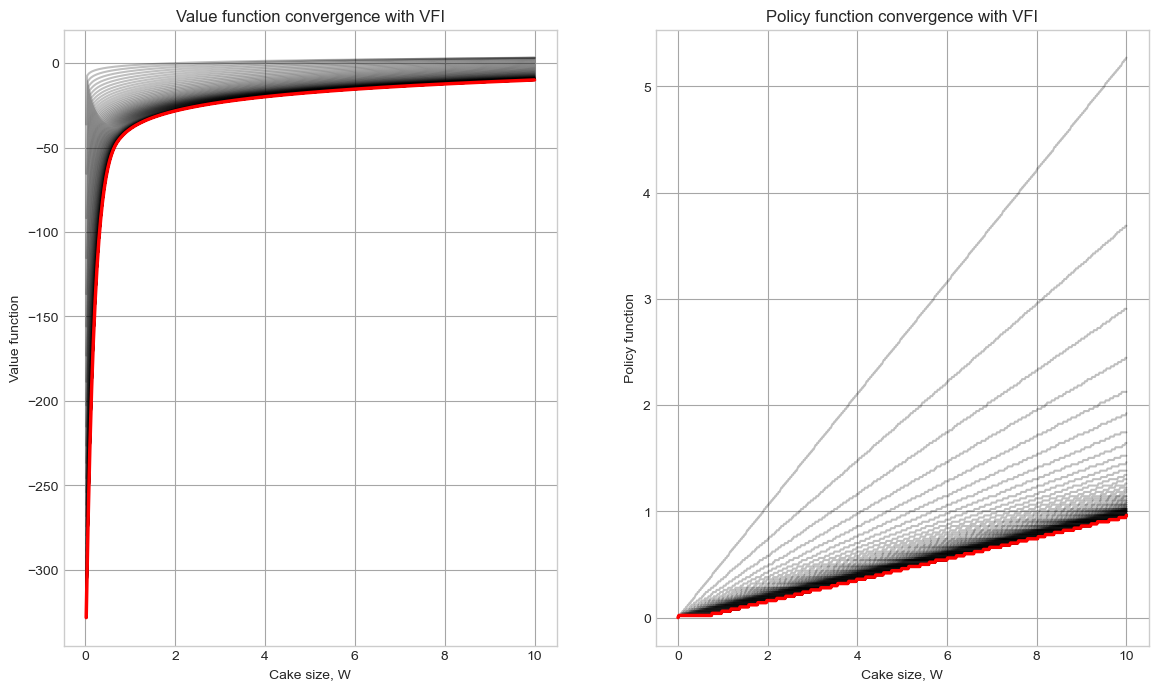

In [179]:
beta_values = [0,0.5,0.9]
for beta in beta_values :
    model = wealth_ongrid(beta,Wbar=10,ngrid=500)
    V,c = vfi_plot(model)

We can see from here that as the time discount factor get closer to one it becomes longer and longer to reach convergence.